# Simple graph max cut example

In [10]:
from discopy.quantum.zx import *
from pyzx import draw

from sympy.abc import phi, beta

This notebook implements the simple graph from "Diagrammatic Analysis for Parameterized Quantum
Circuits" from chapter 4.3.

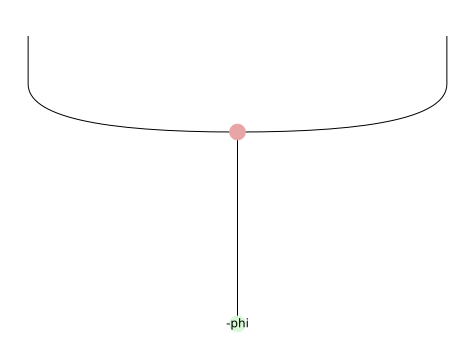

In [11]:
phase_gadget = X(2, 1) >> Z(1,0,-phi)
phase_gadget.draw()

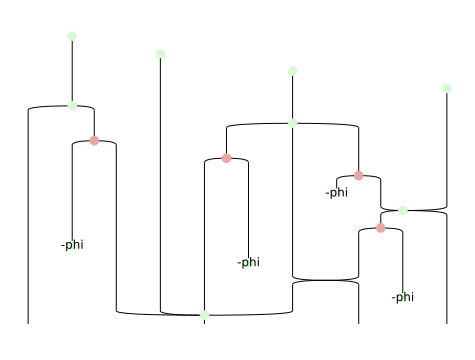

In [12]:
diagram = Z(0, 1) @ Z(0, 1) @Z(0, 1) @Z(0, 1) 
diagram = diagram >> Z(1, 2) @ Id(1) @ Z(1, 3) @ Id(1)
diagram = diagram >> Id(1) @ X(1, 2) @ Id(1) @ X(1, 2) @Id(1) @ X(1, 2) @ Id(1)
diagram = diagram >> Id(7) @ Z(1,0,-phi) @ Z(2, 2)
diagram = diagram >> Id(7) @ X(1, 2) @ Id(1)
diagram = diagram >> Id(1) @ Z(1,0,-phi) @ Id(3) @ Z(1,0,-phi) @ SWAP @ Z(1,0,-phi) @ Id(1)
stageone = diagram >> Id(1) @  Z(4, 1) @ Id(2)
stageone.draw()

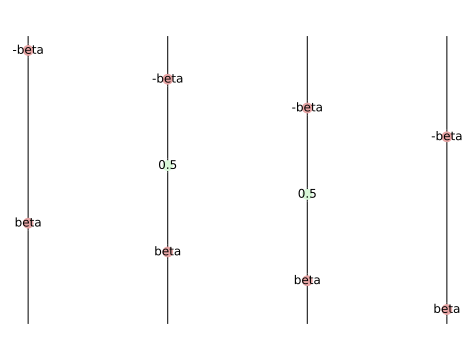

In [13]:
middle_part = X(1,1,-beta) @ X(1,1,-beta)@X(1,1,-beta)@X(1,1,-beta)
middle_part = middle_part >> Id(1) @Z(1,1,phase=0.5) @ Z(1,1,phase=0.5) @ Id(1)
middle_part = middle_part >> X(1,1,beta) @ X(1,1,beta)@X(1,1,beta)@X(1,1,beta)
middle_part.draw()
diagram = stageone >> middle_part



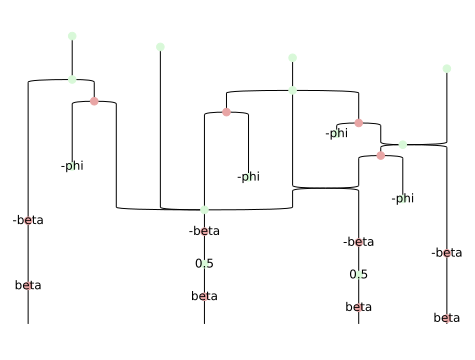

In [14]:
diagram.draw()

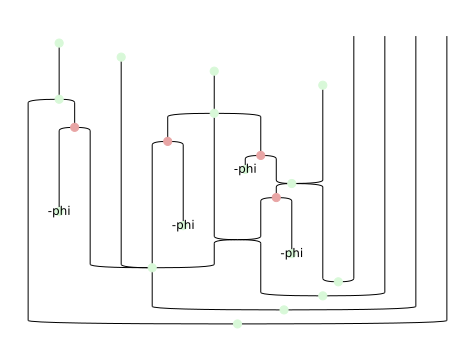

In [15]:
stageone.transpose().draw()

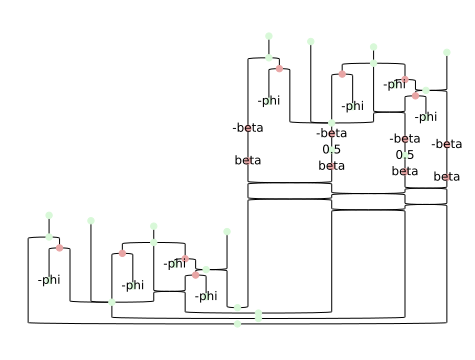

In [16]:
final_diag = diagram >> SWAP @ SWAP     >> Id(1) @ SWAP @ Id(1)         >> SWAP @ SWAP             >> Id(1) @ SWAP @ Id(1) >> stageone.transpose()
final_diag.draw() 

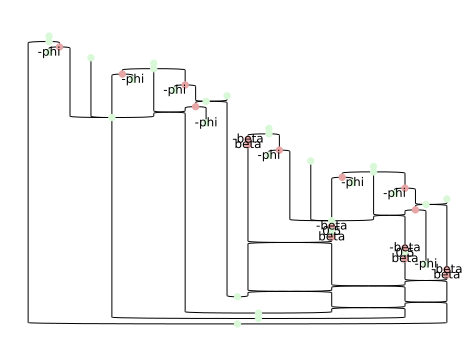

In [17]:
#final_diag.to_gif(*final_diag.normalize(), path="./large.gif")
final_diag.normal_form().draw()